# PS3： Geometry

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['lines.linewidth'] = 1

## 1.Calibration
### 1.1 Projection Matrix M

In [2]:
# Load data
with open('pts2d-pic_a.txt', 'r') as f:
    pts2d_a = np.array([list(int(n) for n in line.split()) for line in f])
with open('pts2d-pic_b.txt','r') as f:
    pts2d_b = np.array([list(int(n) for n in line.split()) for line in f])
with open('pts3d.txt','r') as f:
    pts3d = np.array([list(float(n) for n in line.split()) for line in f])
with open('pts2d-norm-pic_a.txt','r') as f:
    pts2d_a_norm = np.array([list(float(n) for n in line.split()) for line in f])
with open('pts3d-norm.txt','r') as f:
    pts3d_norm = np.array([list(float(n) for n in line.split()) for line in f])

print('pts2d_a.shape =', pts2d_a.shape)
print('pts3d-norm.shape =', pts3d_norm.shape)

pts2d_a.shape = (20, 2)
pts3d-norm.shape = (20, 3)


In [16]:
def projection_matrix(pts2d, pts3d):
    """
    Compute projection matrix from corresponding 2D and 3D points.

    Args:
        pts2d: 2D points in shape (N, 2)
        pts3d: 3D points in shape (N, 3)

    Returns:
        P: projection matrix in shape (3, 4)
    """
    num_points = pts3d.shape[0]
    num_variables = 11
    A = np.zeros((2 * num_points, num_variables))
    b = np.zeros((2 * num_points, 1))

    for ix, ([u, v], [x, y, z]) in enumerate(zip(pts2d, pts3d)):
        A[2*ix, :]   = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z]
        A[2*ix+1, :] = [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z]
        b[2*ix]      = u
        b[2*ix+1]    = v

    P = np.linalg.lstsq(A, b, rcond=None)[0]
    P = np.append(P, 1).reshape(3, 4)
    return P


In [17]:
#calculate projection matrix from a
M = projection_matrix(pts2d_a_norm, pts3d_norm)
print('Projection matrix:', M)

Projection matrix: [[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]


In [18]:
test_3d = pts3d_norm[-1]
test_3d = np.append(test_3d, 1).reshape(4, 1)
cal_2d = np.matmul(M, test_3d)
cal_2d = cal_2d / cal_2d[-1]
u, v = pts2d_a_norm[-1]
resid = np.sqrt((u - cal_2d[0])**2 + (v - cal_2d[1])**2)

test_3d_flat = test_3d.ravel()
cal_2d_flat = cal_2d.ravel()

# print results
print('Test 3D point:', test_3d_flat)
print('Calculated 2D point:', cal_2d_flat)
print('Actual 2D point:', pts2d_a_norm[-1])
print('Residual:', resid)

Test 3D point: [1.2323 1.4421 0.4506 1.    ]
Calculated 2D point: [ 0.14190586 -0.45183985  1.        ]
Actual 2D point: [ 0.1406 -0.4527]
Residual: [0.00156369]


### 1.2 Random Sampling

In [30]:
def smp(pts2d, pts3d, train_size):
    #print('pts2d.shape =', pts2d.shape)
    num_points = pts3d.shape[0]
    min_avg_resid = 1000000
    best_M = None
    residual = []
    k_values = []
    for i in range(10):
        perm = np.random.permutation(num_points)
        #validation set
        val_ix = perm[:4]
        print('Validation set:', val_ix)
        
        #training set
        #calculate projection matrix from training set
        for k in train_size:
            trin_ix = np.random.permutation(perm[4:])[:k]
            print('Training set:', trin_ix)
            M = projection_matrix(pts2d[trin_ix], pts3d[trin_ix])
            
            #calculate average residual from validation set
            pts3d_val = pts3d[val_ix]
            pts3d_val = np.column_stack((pts3d_val, np.ones(pts3d_val.shape[0])))
            proj =  np.matmul(M, pts3d_val.T)
            
            #calculate the error
            proj = proj / proj[-1]
            u, v = pts2d[val_ix,0], pts2d[val_ix,1]
            resid = np.sqrt((u - proj[0])**2 + (v - proj[1])**2)
            
            avg_resid = np.mean(resid)
            residual.append(avg_resid)
            if avg_resid < min_avg_resid:
                min_avg_resid = avg_resid
                best_M = M
            print('#{:d}: k={:02d}, residual={:0.2f}'.format(i, k, avg_resid))
            k_values = k_values + [k]
        print('-------------------------------------')
    print('Best M:', best_M)
    return best_M, k_values, residual



In [41]:
train_size = [8, 12, 16]
best_M,k_values, residual = smp(pts2d_b, pts3d, train_size)

Validation set: [4 8 9 6]
Training set: [17  1 16 11 12 14 18  5]
#0: k=08, residual=1.92
Training set: [13 15 14  3 19  1 18 11 16  0  2  7]
#0: k=12, residual=1.26
Training set: [18 11 17 13  7  2 19 10 16 15  5  1  0 12  3 14]
#0: k=16, residual=1.07
-------------------------------------
Validation set: [ 4 13  8  5]
Training set: [14 18  0  7 12  6 17  2]
#1: k=08, residual=1.52
Training set: [12 15 18  6  1 16 17  9 10 11  2  0]
#1: k=12, residual=1.26
Training set: [18  9  1 16  0  7 19  6 14 11 15 10  2 17  3 12]
#1: k=16, residual=1.24
-------------------------------------
Validation set: [18  5 15 17]
Training set: [12 11 19 16  7 14  9  2]
#2: k=08, residual=2.93
Training set: [ 9  4 16  0  8 12 14  7  1 19 11  6]
#2: k=12, residual=1.26
Training set: [ 7  0  1 16  2 19  4 13 12 10  8 11 14  6  3  9]
#2: k=16, residual=1.17
-------------------------------------
Validation set: [12 15  4 18]
Training set: [16 11  5  9 13  1 17  0]
#3: k=08, residual=1.37
Training set: [ 1  2  

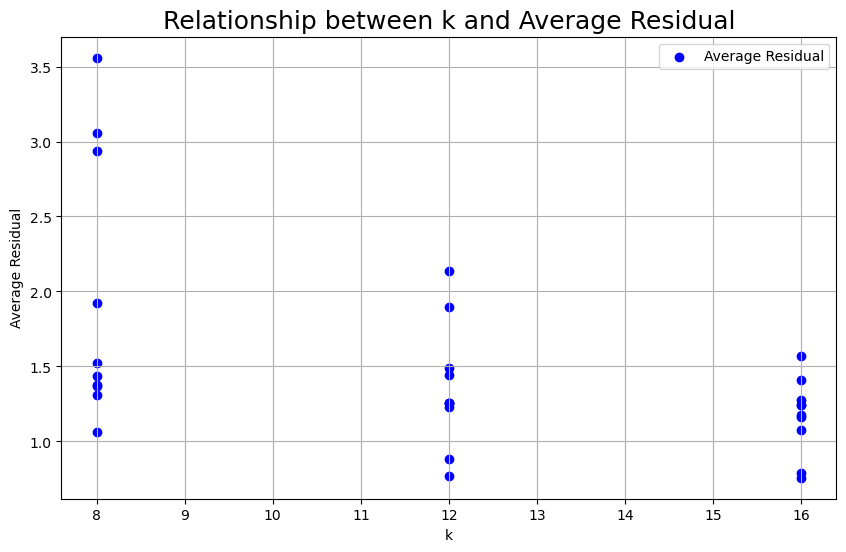

In [42]:
#plot residual
plt.figure(figsize=(10, 6))
plt.scatter(k_values, residual, c='blue', marker='o', label='Average Residual')
plt.xlabel('k')
plt.ylabel('Average Residual')
plt.title('Relationship between k and Average Residual')
plt.legend()
plt.grid(True)
plt.show()

As we see from the figure, a bigger k always correspond to a lower average residual. The reasons can be:
* **Richer Information**: As k increases, the model gets more data points to compute the projection matrix. Having more data generally means that the model can capture the underlying structure better. 
* **Reduced Effect of Outliers**: With a smaller set of data points, an outlier can have a strong influence on the result. With more data points, the influence of any single outlier diminishes, leading to a more robust model.
* **Overfitting vs. Generalization**: When using a small number of points, the model might overfit to those specific points, which means it performs exceptionally well on them but might perform poorly on new data points. As you increase the number of data points, the model becomes more generalized and often provides better performance on a validation set.



### 1.3 Find the camera center

In [43]:
def camera_center(P):
    """
    Compute the camera center matrix from the projection matrix.

    Args:
        P: projection matrix in shape (3, 4)

    Returns:
        C: camera center in shape (3, 1)
    """
    A = P[:, 0:3]
    b = P[:, 3]
    C = -np.linalg.inv(A) @ b
    return C

#calculate camera center
C = camera_center(best_M)
print('Camera center:', C)

Camera center: [303.10929046 307.18131343  30.42222259]


## 2.Fundamental Matrix Estimation
### 2.1 Least squares function to solve fundamental matrix

In [72]:
def fundamental_matrix(pts2d_1, pts2d_2):
    """
    Compute fundamental matrix from corresponding 2D points.

    Args:
        pts2d_1: 2D points in shape (N, 2)
        pts2d_2: 2D points in shape (N, 2)

    Returns:
        F: fundamental matrix in shape (3, 3)
    """
    num_points = pts2d_1.shape[0]
    A = np.zeros((num_points, 9))
    for ix, ([u1, v1], [u2, v2]) in enumerate(zip(pts2d_1, pts2d_2)):
        A[ix, :] = [u2*u1, u2*v1, u2, v2*u1, v2*v1, v2, u1, v1, 1]
    u, s, vt = np.linalg.svd(A.T @ A)
    F = vt[-1, :].reshape((3, 3))
    # F = np.linalg.svd(F)[0] @ np.diag([1, 1, 0]) @ np.linalg.svd(F)[2]
    return F

In [80]:
F = fundamental_matrix(pts2d_a, pts2d_b)
print('Fundamental matrix:\n', F)

Fundamental matrix:
 [[-6.60698417e-07  7.91031620e-06 -1.88600197e-03]
 [ 8.82396296e-06  1.21382933e-06  1.72332901e-02]
 [-9.07382303e-04 -2.64234650e-02  9.99500092e-01]]


### 2.2 Rank constraint

In [82]:
# F = np.linalg.svd(F)[0] @ np.diag([1, 1, 0]) @ np.linalg.svd(F)[2]
u, s, vt = np.linalg.svd(F)
F = (u[:, :2]*s[:2]) @ vt[:2, :]
print('Reduced rank Fundamental matrix:\n', F)

Reduced rank Fundamental matrix:
 [[-5.36264198e-07  7.90364770e-06 -1.88600204e-03]
 [ 8.83539184e-06  1.21321685e-06  1.72332901e-02]
 [-9.07382265e-04 -2.64234650e-02  9.99500092e-01]]


### 2.3 Epipolar lines

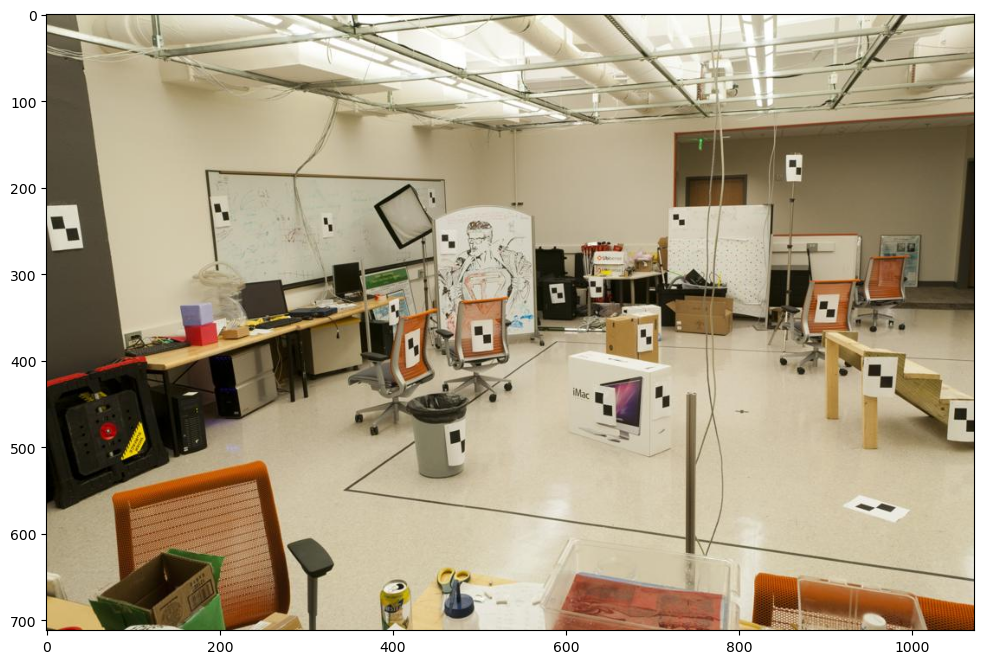

In [83]:
#load image_b
img_b = cv.imread('pic_b.jpg')
img_b = cv.cvtColor(img_b, cv.COLOR_BGR2RGB)
plt.imshow(img_b)

In [95]:
def get_epipolar_lines(pts, F):
    """
    Compute epipolar lines from corresponding 2D points and fundamental matrix.

    Args:
        pts: 2D points in shape (N, 2)
        F: fundamental matrix in shape (3, 3)

    Returns:
        lines: epipolar lines in shape (N, 3)
    """
    pts = np.column_stack((pts, np.ones(pts.shape[0])))
    lines = (F @ pts.T).T
    print('lines.shape =', lines.shape)
    return lines

In [96]:
def plot_lines(ax, lines, pts):
    h,w = pts.shape[:-1]
    print('h,w =', h, w)
    edge_l = np.array([1,0,0])
    edge_r = np.array([-1,0,w])

    for l in lines:
        p1 = np.cross(l, edge_l)
        p2 = np.cross(l, edge_r)
        p1 = p1/p1[-1]
        p2 = p2/p2[-1]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red')
    return


lines.shape = (20, 3)
h,w = 712 1072


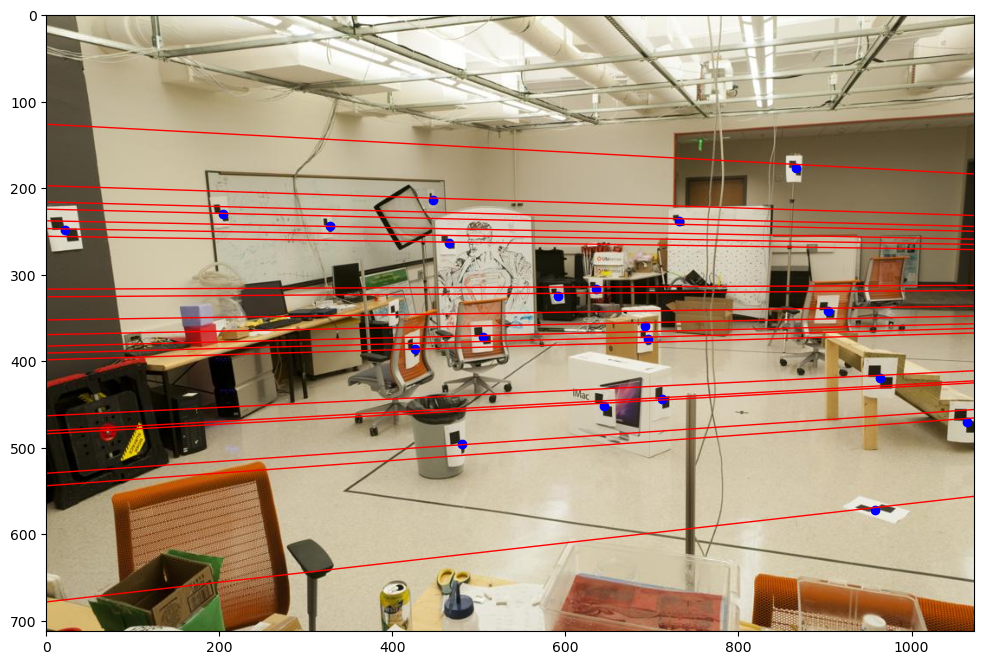

In [97]:
#plot epipolar lines
fig, ax = plt.subplots()
ax.imshow(img_b)
ax.set_xlim(0, img_b.shape[1])
ax.set_ylim(img_b.shape[0], 0) 

ax.plot(pts2d_b[:,0], pts2d_b[:,1], 'o', color='blue')

lines = get_epipolar_lines(pts2d_a, F)
plot_lines(ax, lines, img_b)

### 2.4 Normalization

In [98]:
def normalize(pts):
    """
    Normalize 2D points.

    Args:
        pts: 2D points in shape (N, 2)

    Returns:
        pts_norm: normalized 2D points in shape (N, 2)
        T: normalization matrix in shape (3, 3)
    """
    pts_norm = np.zeros(pts.shape)
    T = np.zeros((3, 3))

    u_mean = np.mean(pts[:, 0])
    v_mean = np.mean(pts[:, 1])
    u_std = np.std(pts[:, 0])
    v_std = np.std(pts[:, 1])
    
    # construct T
    T[0, 0] = 1 / u_std
    T[1, 1] = 1 / v_std
    T[0, 2] = -u_mean / u_std
    T[1, 2] = -v_mean / v_std
    T[2, 2] = 1

    pts = np.column_stack((pts, np.ones(pts.shape[0])))
    pts_norm = (T @ pts.T).T
    return pts_norm[:,:-1], T


In [100]:
# normalize points
pts2d_a_norm, Ta = normalize(pts2d_a)
pts2d_b_norm, Tb = normalize(pts2d_b)
print('pts2d_a_norm.shape =', pts2d_a_norm.shape)
print('pts2d_b_norm.shape =', pts2d_b_norm.shape)
# calculate fundamental matrix
F_norm = fundamental_matrix(pts2d_a_norm, pts2d_b_norm)
u, s, vt = np.linalg.svd(F_norm)
F_norm = (u[:, :2]*s[:2]) @ vt[:2, :]
print('Reduced rank Fundamental matrix:\n', F_norm)

# inverse transform
F = Tb.T @ F_norm @ Ta
print('Fundamental matrix:\n', F)

pts2d_a_norm.shape = (20, 2)
pts2d_b_norm.shape = (20, 2)
Reduced rank Fundamental matrix:
 [[ 0.01242059 -0.08400078 -0.02523535]
 [-0.04754158  0.00576788 -0.68025346]
 [-0.1186818   0.7157386   0.02730938]]
Fundamental matrix:
 [[ 2.02478523e-07 -2.78039315e-06  6.94781145e-04]
 [-1.92581510e-06  4.74398800e-07 -5.59813726e-03]
 [ 4.16157075e-05  7.69192568e-03 -1.78588215e-01]]


### 2.5 Epipolar lines after normalization

lines.shape = (20, 3)
h,w = 712 1072


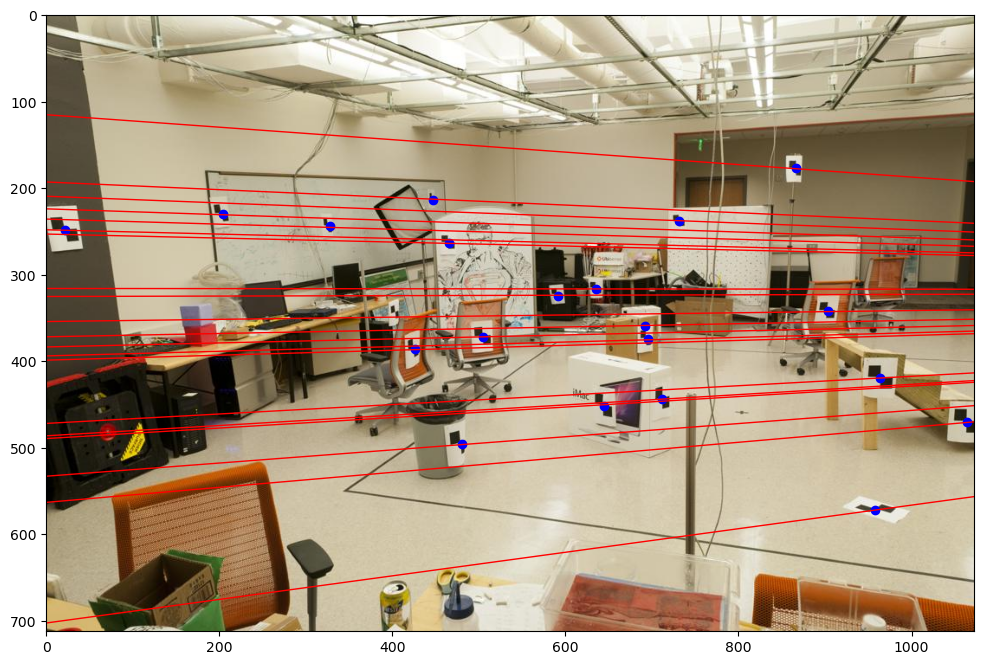

In [101]:
#plot epipolar lines
fig, ax = plt.subplots()
ax.imshow(img_b)
ax.set_xlim(0, img_b.shape[1])
ax.set_ylim(img_b.shape[0], 0) 

ax.plot(pts2d_b[:,0], pts2d_b[:,1], 'o', color='blue')

lines = get_epipolar_lines(pts2d_a, F)
plot_lines(ax, lines, img_b)